In [6]:
#!wget  https://s3.amazonaws.com/ml-lab-mggaska/ml-lab-keras-to-tf/model.h5

--2019-04-10 16:00:10--  https://s3.amazonaws.com/ml-lab-mggaska/ml-lab-keras-to-tf/model.h5
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.129.205
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.129.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209602136 (200M) [application/x-www-form-urlencoded]
Saving to: ‘model.h5’

model.h5            100%[===================>] 199.89M  49.6MB/s    in 4.2s    

2019-04-10 16:00:14 (48.1 MB/s) - ‘model.h5’ saved [209602136/209602136]



In [7]:
#!wget https://s3.amazonaws.com/ml-lab-mggaska/ml-lab-keras-to-tf/model.json

--2019-04-10 16:00:14--  https://s3.amazonaws.com/ml-lab-mggaska/ml-lab-keras-to-tf/model.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.137.94
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.137.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79739 (78K) [application/json]
Saving to: ‘model.json’

model.json          100%[===================>]  77.87K  --.-KB/s    in 0.002s  

2019-04-10 16:00:14 (31.8 MB/s) - ‘model.json’ saved [79739/79739]



In [3]:
#!pip install configobj

In [8]:
import keras
from keras.models import model_from_json
%matplotlib inline
import cv2
import matplotlib
import pylab as plt
import numpy as np
import util
import sys
from config_reader import config_reader

In [9]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights('model.h5')

Instructions for updating:
Colocations handled automatically by placer.


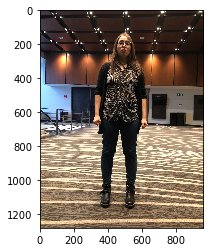

In [10]:
test_image = 'test.jpeg'
oriImg = cv2.imread(test_image) # B,G,R order
plt.imshow(oriImg[:,:,[2,1,0]]);

In [11]:
sys.getsizeof(oriImg)

3686528

In [12]:
param, model_params = config_reader()
multiplier = [x * model_params['boxsize'] / oriImg.shape[0] for x in param['scale_search']]
multiplier

[0.14375, 0.2875, 0.43125, 0.575]

In [13]:
multiplier[3]
scale = multiplier[3]

In [14]:
heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))

In [15]:

imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_params['stride'], model_params['padValue'])        
#plt.imshow(imageToTest_padded[:,:,[2,1,0]]);
 

In [16]:
sys.getsizeof(imageToTest_padded)

1218944

In [17]:
input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2)) # required shape (1, width, height, channels) 
output_blobs = loaded_model.predict(input_img)


In [18]:
heatmap = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
heatmap = np.squeeze(output_blobs[1]) # output 1 is heatmaps


In [23]:
heatmap.shape

(92, 69, 19)

In [22]:
heatmap.flatten()

array([ 1.1087482e-04, -2.0300160e-05,  7.6819073e-05, ...,
        7.6660785e-05,  5.1488772e-05,  9.9833846e-01], dtype=float32)

In [ ]:
heatmap = cv2.resize(heatmap, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)


In [20]:
from scipy.ndimage.filters import gaussian_filter
all_peaks = []
peak_counter = 0

for part in range(19-1):
    map_ori = heatmap[:,:,part]
    map = gaussian_filter(map_ori, sigma=3)
    
    map_left = np.zeros(map.shape)
    map_left[1:,:] = map[:-1,:]
    map_right = np.zeros(map.shape)
    map_right[:-1,:] = map[1:,:]
    map_up = np.zeros(map.shape)
    map_up[:,1:] = map[:,:-1]
    map_down = np.zeros(map.shape)
    map_down[:,:-1] = map[:,1:]
    
    peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > param['thre1']))
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
    peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)

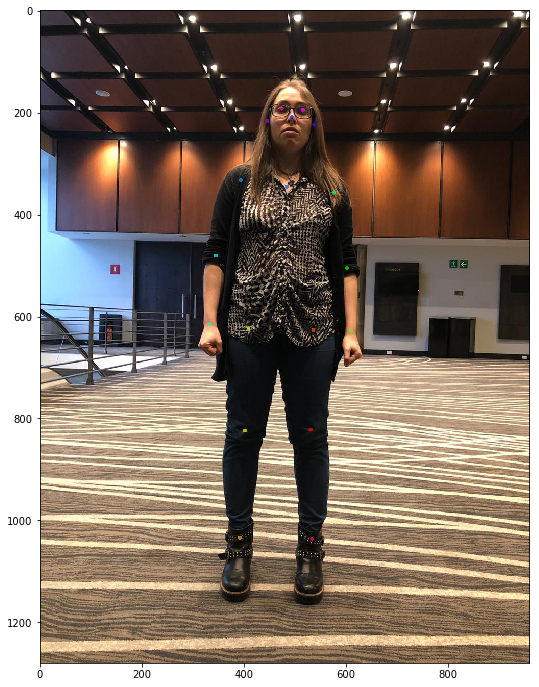

In [21]:
# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
cmap = matplotlib.cm.get_cmap('hsv')

canvas = cv2.imread(test_image) # B,G,R order

for i in range(18):
    rgba = np.array(cmap(1 - i/18. - 1./36))
    rgba[0:3] *= 255
    for j in range(len(all_peaks[i])):
        cv2.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)

to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)